<a href="https://colab.research.google.com/github/Singhsansar/Sentiment-Analysis/blob/main/Sentiment_Analyis_moviedatabase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
path = "/content/drive/MyDrive/NLP/a1_IMDB_Dataset.csv"
data = pd.read_csv(path)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.shape

(50000, 2)

In [ ]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

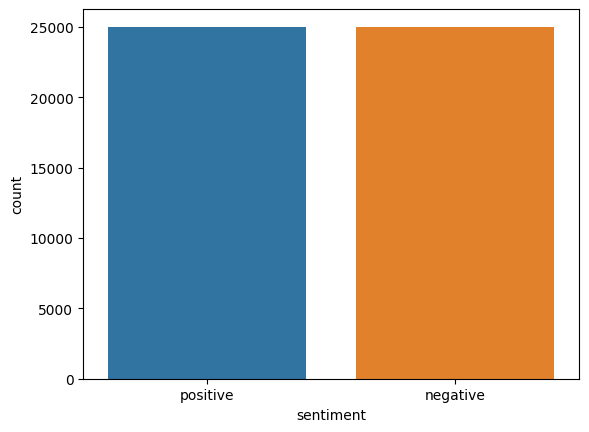

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data= data)

In [ ]:
data["review"][2] #just checking to access one review

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:


#calling prepeovessign text function
X = []
sentences = list(data['review'])

for sen in sentences:
  X.append(preprocess_text(sen))

In [ ]:
X[2] #printing the values

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
# Converting sentiment labels to 0 & 1

y = data['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3 , random_state=42)


#**prepration of the embedding layer**

In [ ]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_length = len(word_tokenizer.word_index) +1
vocab_length

87372

In [ ]:
from tensorflow.keras.utils import pad_sequences

In [ ]:
max_len = 100;
X_train = pad_sequences(X_train,padding="post",maxlen=max_len)
X_test = pad_sequences(X_test,padding="post",maxlen=max_len)

In [ ]:
#Load glove word embedding and create embedding dictonary
#no idea about the glove word_embeddings
from numpy import asarray
from numpy import zeros
glove_path = "/content/drive/MyDrive/NLP/a2_glove.6B.100d.txt"
embeddings_dictionary = dict()
glove_file = open(glove_path,encoding = 'utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(87372, 100)

#Model Training

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          8737200   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 8747201 (33.37 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 8737200 (33.33 MB)
_________________________________________________________________
None


In [ ]:
snn_model_history = snn_model.fit(X_train,y_train,batch_size = 128,epochs=10,verbose=1,validation_split= 0.2)

Epoch 1/10
219/219 [==============================] - 2s 8ms/step - loss: 0.5642 - acc: 0.7096 - val_loss: 0.5043 - val_acc: 0.7603
Epoch 2/10
219/219 [==============================] - 2s 8ms/step - loss: 0.4468 - acc: 0.7965 - val_loss: 0.4930 - val_acc: 0.7650
Epoch 3/10
219/219 [==============================] - 1s 6ms/step - loss: 0.4063 - acc: 0.8207 - val_loss: 0.5007 - val_acc: 0.7609
Epoch 4/10
219/219 [==============================] - 1s 7ms/step - loss: 0.3833 - acc: 0.8336 - val_loss: 0.5131 - val_acc: 0.7601
Epoch 5/10
219/219 [==============================] - 2s 7ms/step - loss: 0.3644 - acc: 0.8409 - val_loss: 0.5284 - val_acc: 0.7580
Epoch 6/10
219/219 [==============================] - 2s 9ms/step - loss: 0.3500 - acc: 0.8498 - val_loss: 0.5400 - val_acc: 0.7530
Epoch 7/10
219/219 [==============================] - 2s 9ms/step - loss: 0.3396 - acc: 0.8545 - val_loss: 0.5682 - val_acc: 0.7436
Epoch 8/10
219/219 [==============================] - 2s 9ms/step - loss: 0.

In [ ]:
score = snn_model.evaluate(X_test,y_test,verbose= 1)

469/469 [==============================] - 2s 4ms/step - loss: 0.6306 - acc: 0.7320


In [ ]:
print("Test Scores",score[0])
print("Test Accuracy",score[1])

Test Scores 0.630630612373352
Test Accuracy 0.7319999933242798


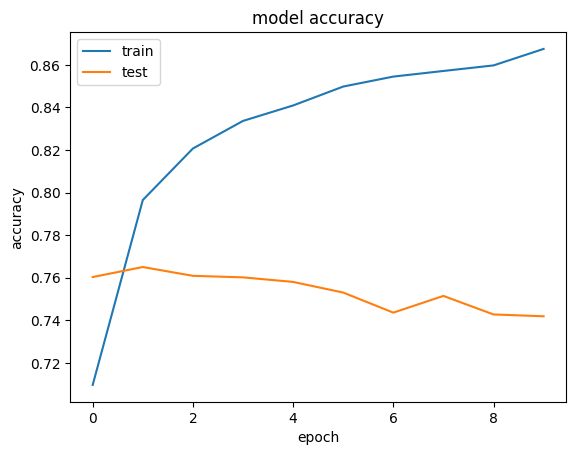

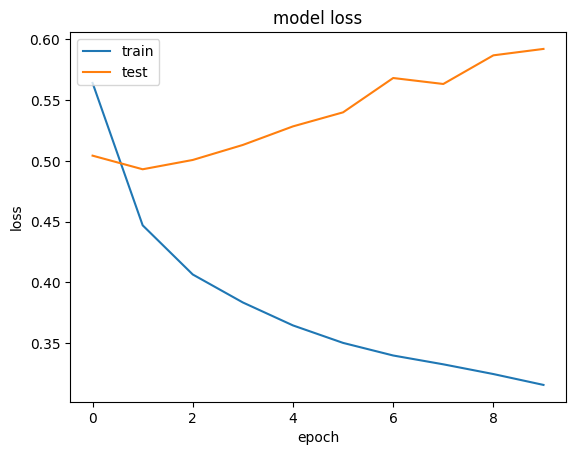

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#RNN: LSTM


In [ ]:
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_length, 100,weights = [embedding_matrix],input_length = max_len , trainable = False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1,activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['acc'])
print(model.summary());


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          8737200   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8854577 (33.78 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 8737200 (33.33 MB)
_________________________________________________________________
None


In [ ]:
lstm_model_history = model.fit(X_train,y_train,batch_size = 128,epochs=10,verbose=1,validation_split= 0.2)

Epoch 1/10
219/219 [==============================] - 100s 436ms/step - loss: 0.5544 - acc: 0.7237 - val_loss: 0.4678 - val_acc: 0.7901
Epoch 2/10
219/219 [==============================] - 89s 408ms/step - loss: 0.4372 - acc: 0.8059 - val_loss: 0.3961 - val_acc: 0.8227
Epoch 3/10
219/219 [==============================] - 89s 406ms/step - loss: 0.3932 - acc: 0.8287 - val_loss: 0.3770 - val_acc: 0.8380
Epoch 4/10
219/219 [==============================] - 98s 450ms/step - loss: 0.3568 - acc: 0.8458 - val_loss: 0.3395 - val_acc: 0.8536
Epoch 5/10
219/219 [==============================] - 100s 458ms/step - loss: 0.3424 - acc: 0.8537 - val_loss: 0.3374 - val_acc: 0.8536
Epoch 6/10
219/219 [==============================] - 87s 395ms/step - loss: 0.3153 - acc: 0.8697 - val_loss: 0.3269 - val_acc: 0.8631
Epoch 7/10
219/219 [==============================] - 105s 481ms/step - loss: 0.2989 - acc: 0.8746 - val_loss: 0.3141 - val_acc: 0.8657
Epoch 8/10
219/219 [==============================] 

In [ ]:
import tensorflow as tf
model.save("/content/drive/MyDrive/NLP/LSTMmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
score = model.evaluate(X_test,y_test, verbose  = 1)

469/469 [==============================] - 31s 67ms/step - loss: 0.3453 - acc: 0.8641


In [ ]:
print("Test Scores",score[0])
print("Test Accuracy",score[1])

Test Scores 0.34531068801879883
Test Accuracy 0.864133358001709


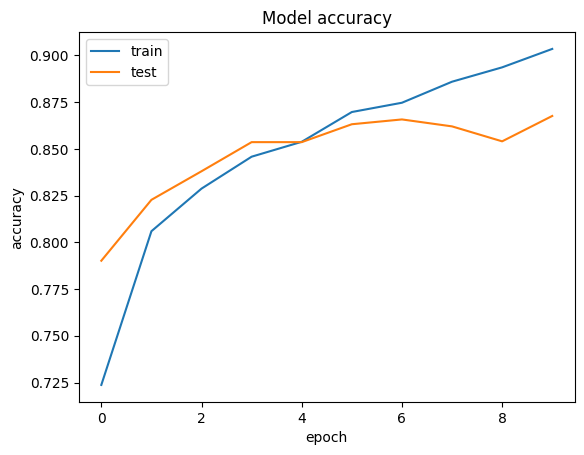

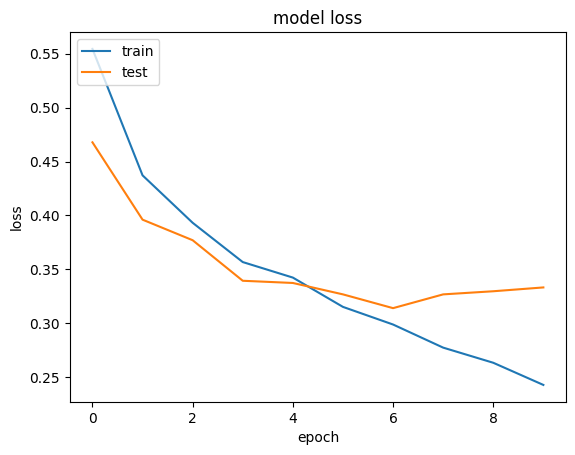

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()


plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch'),
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#Making Predection in Live comments of IMDB data

In [ ]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("/content/drive/MyDrive/NLP/a3_IMDb_Unseen_Reviews.csv")
sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [ ]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']
unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [ ]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=max_len)

In [ ]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = model.predict(unseen_padded)
unseen_sentiments

1/1 [==============================] - 2s 2s/step


array([[0.97857887],
       [0.9944355 ],
       [0.08735961],
       [0.34324223],
       [0.9756368 ],
       [0.01659509]], dtype=float32)

In [ ]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)
df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])
dataframe=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)
dataframe.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')
dataframe.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.8
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,0.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,3.4
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.2


#Analysis of single data

In [ ]:
single_sentence = input()
single_sentence = preprocess_text(single_sentence)
single_sentence = preprocess_text(single_sentence)
single_sentence_tokenized = word_tokenizer.texts_to_sequences([single_sentence])
single_sentence_padded = pad_sequences(single_sentence_tokenized, padding='post', maxlen=max_len)
single_sentence_sentiment = model.predict(single_sentence_padded)
print(single_sentence_sentiment)
if single_sentence_sentiment > 0.5:
    print("Postive")

else:
      print("Negative")


I absolutely loved the acting and the plot of the movie. It was a masterpiece!
1/1 [==============================] - 0s 97ms/step
[[0.98942703]]
Postive
